In [208]:
import h5py
import numpy as np
import os
import operator
import pandas as pd
import time
from tqdm import tqdm 
import matplotlib.pyplot as plt
from numpy import linalg as ll

print(os.listdir("./data/train"))

['images_training.h5', 'labels_training.h5']


In [209]:
with h5py.File('./data/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with  h5py.File('./data/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

    # using H['datatest'], H['labeltest'] for test dataset.

print(data_train.shape,label_train.shape)

# using H['datatest'], H['labeltest'] for test dataset.
with h5py.File('./data/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./data/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])
print(data_test.shape,label_test.shape)


(30000, 784) (30000,)
(10000, 784) (2000,)


Showing a sample data. The first example belongs to class 0: T-Shirt/Top

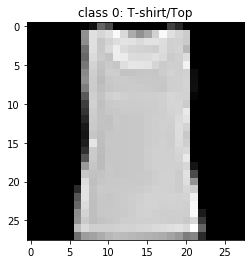

In [210]:
import matplotlib.pyplot as plt
data_train = data_train.reshape((data_train.shape[0], 28, 28))
plt.imshow(data_train[0], cmap=plt.get_cmap('gray'))
plt.title("class " + str(label_train[0]) + ": T-shirt/Top" )
plt.show()

In [211]:
clothClass = {
0: "T-shirt/Top",
1: "Trouser",
2: "Pullover",
3: "Dress",
4: "Coat",
5: "Sandal",
6: "Shirt",
7: "Sneaker",
8: "Bag",
9: "Ankle boot"
}

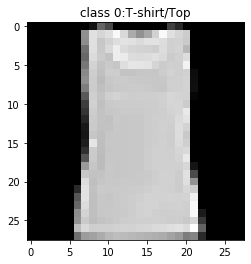

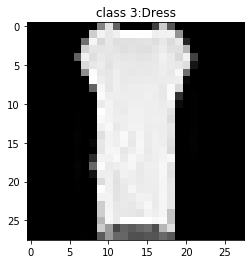

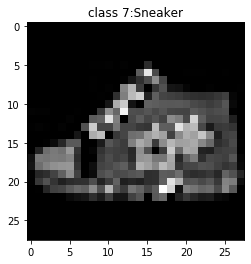

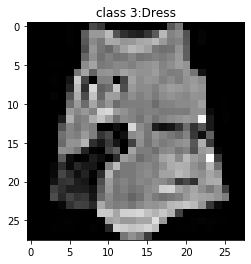

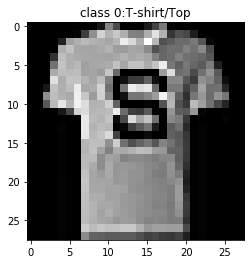

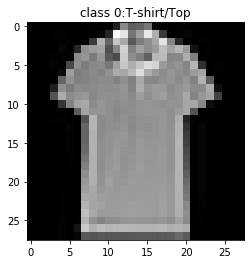

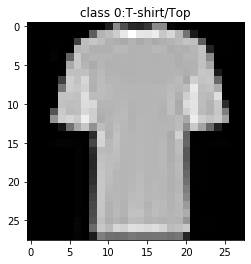

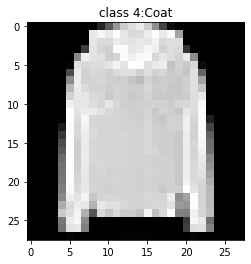

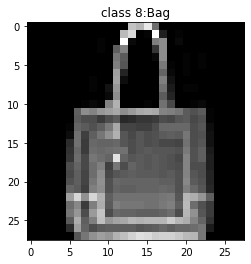

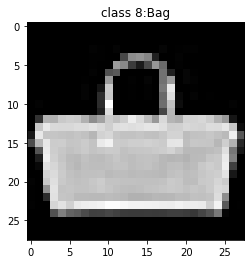

In [212]:
import matplotlib.pyplot as plt
data_train = data_train.reshape((data_train.shape[0], 28, 28))

for i in range(0,10):
    plt.imshow(data_train[i], cmap=plt.get_cmap('gray'))
    classNum = label_train[i]
    plt.title("class " + str(classNum) + ":" + clothClass[classNum] )
    plt.show()

## Data analysis

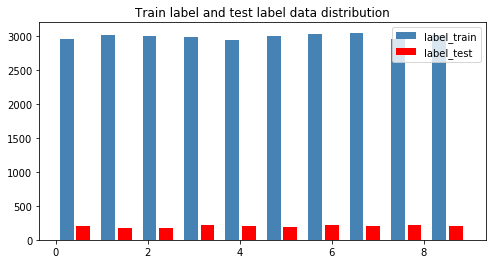

In [360]:
import seaborn as sns


plt.figure(figsize=(8,4))

plt.title("Train label and test label data distribution")
# plt.hist([label_train,label_test], width=0.8, bins=20, color='steelblue',label='train_label')

plt.hist([label_train, label_test],width=0.3, bins=10,color=['steelblue','red'],label=['label_train', 'label_test'])

plt.legend()


## Image SVD

In [213]:
from numpy import linalg as ll
count = 0
lose = 0 #

'''
sum up squre of Sigma, 
testing num_SV, remain value precent greater than 90%;

'''
for i in range(len(data_train)):
    U, Sigma, Vt = ll.svd(data_train[i])
    Sig2 = Sigma**2
    Sig2_sum = np.sum(Sig2)
    remain_pre = np.sum(Sig2[:8])/Sig2_sum
    
    if(remain_pre >= 0.9):
        count += 1
    else:
        lose += 1
print(count, lose)
    
#     print(sum(Sig2[:3]),Sig2_sum, remain_pre )
    
#     Sigma2_remain = sum(Sig2[:2])
    
#     print (Sig2_remain/sum(Sig2) )

29994 6


In [215]:

def img_compress(data_train,num_sv=8, img_num=1):
    '''
        compress image 
    '''

    compress_img = []

    for i in range(img_num):
#         plt.imshow(data_train[i], cmap=plt.get_cmap('gray')) 
#         classNum = label_train[i]
#         plt.title("class " + str(classNum) + ":" + clothClass[classNum] )    
        U, Sigma, Vt = ll.svd(data_train[i])

        sigRecon = np.diag(Sigma[:num_sv]) # cut first 8 
        reconMat = np.dot(U[:,:num_sv],sigRecon).dot(Vt[:num_sv,:]) # 截取 U, Vt ; reconvert to matrix

        reconMat = np.reshape(reconMat, (784))

        compress_img.append(reconMat)

    return  compress_img
#         print(reconMat)
#         plt.imshow(reconMat, cmap=plt.get_cmap('gray'))
#         plt.show()  
#         print(reconMat)

def compress_dataset(img_num,com_np_data):
    print(com_np_data.shape)
    with h5py.File("./data/test/images_compress_5dims.h5", "w") as f:
        f.create_dataset('compress_datatest', data=com_np_data)
        f.close()
        

    

In [200]:
com_data = img_compress(data_train,num_sv=5, img_num=data_train.shape[0])

com_np_data = np.array(com_data)

# com_np_data.shape[0]

compress_dataset(com_np_data.shape[0],com_np_data)


(30000, 784)


## Machien learning methods

### 1. KNN

In [364]:
# 欧拉距离公式
def d_euc(x, y):
	d = np.sqrt(np.sum(np.square(x - y)))
	return d


# vote the most  probabolity
def majority_voting(class_count):
	# 多数表决函数 
	sorted_class_count = sorted(class_count.items(), key=operator.itemgetter(1), reverse=True)
	return sorted_class_count


def knn_classify(test_data, train_data, labels,k):
	'''
	knn classify for cloth classification
	base on shiyanluo.com  example

	I am rookie (crying T^T

	'''
	distances = np.array([])

	for i_data in train_data:

		d = d_euc(test_data, i_data) 
		distances = np.append(distances, d) # collect each distance, ranking min later

	sorted_distance_index = distances.argsort() # get the  after sort index 
	sorted_distance = np.sort(distances)
	r = (sorted_distance[k] + sorted_distance[k-1])/2

	class_count = {}

	for i in range(k):
		vote_label = labels[sorted_distance_index[i]]
		class_count[vote_label] = class_count.get(vote_label, 0) + 1

	final_label = majority_voting(class_count)
	return final_label[0][0], r


def KNN_get_accuracy(test_labels, pred_labels):
	'''
		accuracy
	''' 
	correct = np.sum(test_labels == pred_labels)  # 计算预测正确的数据个数
	n = len(test_labels)  # 总测试集数据个数
	accur = correct/n
	return accur


### 2. Logistic Regression(Softmax regression)

In [419]:
class SoftmaxRegression(object):
	def __init__(self):
		pass

	def softmax_fit(self, X, y, W, lr = 0.1,  n_iter= 100, tol = 1e-7, batch_size = 20):
		W_pre = W.copy()
		loss_hist = [self._softmax_loss(X, y, W)] # store history of loss 
		dims = X.shape[0]
		nbatches = int(np.ceil(float(dims)/batch_size))

		for niter in tqdm(range(n_iter)):

			mix_ids = np.random.permutation(dims) # mix data 
			for i in range(nbatches):
				# get the i-th batch
				batch_ids = mix_ids[batch_size*i:min(batch_size*(i+1), dims)] 
				X_min_batch, y_min_batch = X[batch_ids], y[batch_ids]
				W -= lr*self._softmax_GD(X_min_batch, y_min_batch, W) 
			loss_hist.append(self._softmax_loss(X, y, W))
			if np.linalg.norm(W - W_pre)/W.size < tol:
				break 
			W_pre = W.copy()

		return W, loss_hist 

	def _sigmoid(self, x):
		return 1 / (1 + np.exp(-x))

#test relu
	def _relu(self, x): 
		return 1 if np.sum(x) > 0 else 0
	
	def _softmax_GD(self,X,y,w):
		hx = softmax(X.dot(w))
		getLen = range(X.shape[0])
		hx[getLen,y] -= 1
		return X.T.dot(hx) / X.shape[0]
	  
	def _softmax_loss(self,X, y, W):
		hx = softmax(X.dot(W))
		getRange= range(X.shape[0])
		return -np.mean(np.log(hx[getRange, y]))

def softmax(weighted_input):
		X_exp = np.exp(weighted_input)
		partition = X_exp / np.sum(X_exp, axis=1, keepdims=True)
		return partition
    
def pred(W, X):
    hx = softmax(X.dot(W))
    return np.argmax(hx, axis = 1)

In [429]:
def exportCSV(test_labels, pred_labels, accuracy, loss_hist):
	
	df = pd.DataFrame({"test_labels" :test_labels , "pred_labels" : pred_labels})
	df['accuracy'] = accuracy
	df['loss_hist'] = pd.Series(loss_hist)

	df.to_csv("LogisticExportResult" + str(time.time()) +".csv", index=False)
	# numpy.savetxt("foo.csv", test_labels, delimiter=",")

def get_accuracy(test_labels, predi_labels):
	# 准确率计算函数   
	correct = np.sum(predi_labels == test_labels )  # 计算预测正确的数据个数
	n = len(test_labels)  # 总测试集数据个数
	accur = correct/n
	return accur


In [263]:
with h5py.File('./data/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])

classNum = 10
data_test = data_test[0:2000] # just using smalle sclice of test data
# label_test_slice = label_test[0:2000] 

w_init = np.random.randn(data_train.shape[1], classNum)
W, loss_hist= SoftmaxRegression().softmax_fit(data_train, label_train, w_init, n_iter=500, batch_size=20)

predi_labels = pred(W,data_test)
accuracy = get_accuracy(label_test, predi_labels)
print(" Accuracy: %f"%accuracy)




  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 1/500 [00:00<03:42,  2.24it/s]

  0%|          | 2/500 [00:00<03:34,  2.32it/s]

  1%|          | 3/500 [00:01<03:34,  2.32it/s]

  1%|          | 4/500 [00:01<03:31,  2.35it/s]

  1%|          | 5/500 [00:02<03:31,  2.34it/s]

  1%|          | 6/500 [00:02<03:28,  2.37it/s]

  1%|▏         | 7/500 [00:03<03:35,  2.29it/s]

  2%|▏         | 8/500 [00:03<03:29,  2.35it/s]

  2%|▏         | 9/500 [00:03<03:29,  2.35it/s]

  2%|▏         | 10/500 [00:04<03:35,  2.28it/s]

  2%|▏         | 11/500 [00:04<03:31,  2.32it/s]

  2%|▏         | 12/500 [00:05<03:34,  2.27it/s]

  3%|▎         | 13/500 [00:05<03:35,  2.26it/s]

  3%|▎         | 14/500 [00:06<03:29,  2.31it/s]

  3%|▎         | 15/500 [00:06<03:29,  2.31it/s]

  3%|▎         | 16/500 [00:06<03:25,  2.36it/s]

  3%|▎         | 17/500 [00:07<03:26,  2.34it/s]

  4%|▎         | 18/500 [00:07<03:29,  2.30it/s]

  4%|▍         | 19/500 [00:08<03:28,  2.30it/s]

  4%|▍         |

 29%|██▉       | 145/500 [01:01<02:25,  2.44it/s]

 29%|██▉       | 146/500 [01:02<02:24,  2.44it/s]

 29%|██▉       | 147/500 [01:02<02:24,  2.45it/s]

 30%|██▉       | 148/500 [01:02<02:23,  2.44it/s]

 30%|██▉       | 149/500 [01:03<02:22,  2.46it/s]

 30%|███       | 150/500 [01:03<02:22,  2.46it/s]

 30%|███       | 151/500 [01:04<02:21,  2.47it/s]

 30%|███       | 152/500 [01:04<02:20,  2.47it/s]

 31%|███       | 153/500 [01:04<02:20,  2.47it/s]

 31%|███       | 154/500 [01:05<02:19,  2.48it/s]

 31%|███       | 155/500 [01:05<02:20,  2.46it/s]

 31%|███       | 156/500 [01:06<02:19,  2.47it/s]

 31%|███▏      | 157/500 [01:06<02:19,  2.47it/s]

 32%|███▏      | 158/500 [01:07<02:18,  2.47it/s]

 32%|███▏      | 159/500 [01:07<02:17,  2.47it/s]

 32%|███▏      | 160/500 [01:07<02:18,  2.45it/s]

 32%|███▏      | 161/500 [01:08<02:19,  2.43it/s]

 32%|███▏      | 162/500 [01:08<02:23,  2.36it/s]

 33%|███▎      | 163/500 [01:09<02:21,  2.39it/s]

 33%|███▎      | 164/500 [01:09

 58%|█████▊    | 288/500 [02:02<01:32,  2.28it/s]

 58%|█████▊    | 289/500 [02:03<01:35,  2.21it/s]

 58%|█████▊    | 290/500 [02:03<01:34,  2.22it/s]

 58%|█████▊    | 291/500 [02:03<01:32,  2.26it/s]

 58%|█████▊    | 292/500 [02:04<01:31,  2.27it/s]

 59%|█████▊    | 293/500 [02:04<01:29,  2.31it/s]

 59%|█████▉    | 294/500 [02:05<01:27,  2.35it/s]

 59%|█████▉    | 295/500 [02:05<01:27,  2.35it/s]

 59%|█████▉    | 296/500 [02:06<01:27,  2.34it/s]

 59%|█████▉    | 297/500 [02:06<01:26,  2.34it/s]

 60%|█████▉    | 298/500 [02:06<01:26,  2.33it/s]

 60%|█████▉    | 299/500 [02:07<01:26,  2.32it/s]

 60%|██████    | 300/500 [02:07<01:27,  2.29it/s]

 60%|██████    | 301/500 [02:08<01:27,  2.27it/s]

 60%|██████    | 302/500 [02:08<01:30,  2.19it/s]

 61%|██████    | 303/500 [02:09<01:27,  2.24it/s]

 61%|██████    | 304/500 [02:09<01:25,  2.29it/s]

 61%|██████    | 305/500 [02:10<01:27,  2.24it/s]

 61%|██████    | 306/500 [02:10<01:26,  2.24it/s]

 61%|██████▏   | 307/500 [02:10

 86%|████████▌ | 431/500 [03:02<00:27,  2.53it/s]

 86%|████████▋ | 432/500 [03:02<00:26,  2.54it/s]

 87%|████████▋ | 433/500 [03:03<00:26,  2.54it/s]

 87%|████████▋ | 434/500 [03:03<00:25,  2.55it/s]

 87%|████████▋ | 435/500 [03:03<00:25,  2.53it/s]

 87%|████████▋ | 436/500 [03:04<00:25,  2.53it/s]

 87%|████████▋ | 437/500 [03:04<00:25,  2.51it/s]

 88%|████████▊ | 438/500 [03:05<00:24,  2.49it/s]

 88%|████████▊ | 439/500 [03:05<00:24,  2.48it/s]

 88%|████████▊ | 440/500 [03:05<00:24,  2.49it/s]

 88%|████████▊ | 441/500 [03:06<00:23,  2.49it/s]

 88%|████████▊ | 442/500 [03:06<00:23,  2.51it/s]

 89%|████████▊ | 443/500 [03:07<00:22,  2.53it/s]

 89%|████████▉ | 444/500 [03:07<00:22,  2.54it/s]

 89%|████████▉ | 445/500 [03:07<00:21,  2.54it/s]

 89%|████████▉ | 446/500 [03:08<00:21,  2.55it/s]

 89%|████████▉ | 447/500 [03:08<00:20,  2.55it/s]

 90%|████████▉ | 448/500 [03:09<00:20,  2.56it/s]

 90%|████████▉ | 449/500 [03:09<00:20,  2.53it/s]

 90%|█████████ | 450/500 [03:09

 Accuracy: 0.810500


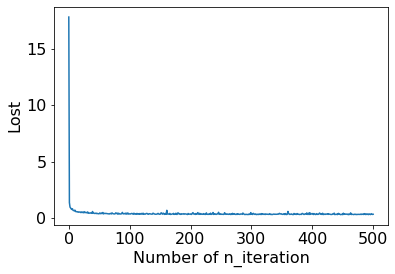

In [264]:
plt.plot(loss_hist)
plt.xlabel('Number of n_iteration', fontsize = 16)
plt.ylabel('Lost', fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show() 

In [356]:
W2, loss_hist2= SoftmaxRegression().softmax_fit(data_train, label_train, w_init,lr = 0.01, n_iter=500, batch_size=20)

predi_labels = pred(W2,data_test)
accuracy = get_accuracy(label_test, predi_labels)
print(" Accuracy: %f"%accuracy)







  0%|          | 0/500 [00:00<?, ?it/s]




  0%|          | 1/500 [00:00<03:41,  2.26it/s]




  0%|          | 2/500 [00:00<03:40,  2.26it/s]




  1%|          | 3/500 [00:01<03:40,  2.25it/s]




  1%|          | 4/500 [00:01<03:38,  2.27it/s]




  1%|          | 5/500 [00:02<03:47,  2.17it/s]




  1%|          | 6/500 [00:02<03:48,  2.16it/s]




  1%|▏         | 7/500 [00:03<03:44,  2.20it/s]




  2%|▏         | 8/500 [00:03<03:44,  2.19it/s]




  2%|▏         | 9/500 [00:04<03:44,  2.19it/s]




  2%|▏         | 10/500 [00:04<03:38,  2.24it/s]




  2%|▏         | 11/500 [00:04<03:40,  2.22it/s]




  2%|▏         | 12/500 [00:05<03:35,  2.27it/s]




  3%|▎         | 13/500 [00:05<03:27,  2.35it/s]




  3%|▎         | 14/500 [00:06<03:32,  2.29it/s]




  3%|▎         | 15/500 [00:06<03:33,  2.27it/s]




  3%|▎         | 16/500 [00:07<03:40,  2.20it/s]




  3%|▎         | 17/500 [00:07<03:35,  2.24it/s]




  4%|▎         | 18/500 [00:08<03:30,  2.29it/s]




  4%|▍

 24%|██▍       | 120/500 [00:52<02:39,  2.39it/s]




 24%|██▍       | 121/500 [00:52<02:38,  2.39it/s]




 24%|██▍       | 122/500 [00:53<02:37,  2.40it/s]




 25%|██▍       | 123/500 [00:53<02:37,  2.40it/s]




 25%|██▍       | 124/500 [00:54<02:33,  2.45it/s]




 25%|██▌       | 125/500 [00:54<02:30,  2.49it/s]




 25%|██▌       | 126/500 [00:54<02:33,  2.44it/s]




 25%|██▌       | 127/500 [00:55<02:31,  2.46it/s]




 26%|██▌       | 128/500 [00:55<02:34,  2.41it/s]




 26%|██▌       | 129/500 [00:56<02:35,  2.39it/s]




 26%|██▌       | 130/500 [00:56<02:34,  2.39it/s]




 26%|██▌       | 131/500 [00:56<02:33,  2.41it/s]




 26%|██▋       | 132/500 [00:57<02:33,  2.39it/s]




 27%|██▋       | 133/500 [00:57<02:34,  2.37it/s]




 27%|██▋       | 134/500 [00:58<02:33,  2.39it/s]




 27%|██▋       | 135/500 [00:58<02:32,  2.39it/s]




 27%|██▋       | 136/500 [00:59<02:30,  2.42it/s]




 27%|██▋       | 137/500 [00:59<02:29,  2.43it/s]




 28%|██▊       | 138/500 [00

 48%|████▊     | 238/500 [01:41<01:51,  2.36it/s]




 48%|████▊     | 239/500 [01:42<01:48,  2.41it/s]




 48%|████▊     | 240/500 [01:42<01:47,  2.42it/s]




 48%|████▊     | 241/500 [01:43<01:44,  2.48it/s]




 48%|████▊     | 242/500 [01:43<01:42,  2.51it/s]




 49%|████▊     | 243/500 [01:43<01:43,  2.48it/s]




 49%|████▉     | 244/500 [01:44<01:43,  2.49it/s]




 49%|████▉     | 245/500 [01:44<01:45,  2.42it/s]




 49%|████▉     | 246/500 [01:45<01:45,  2.42it/s]




 49%|████▉     | 247/500 [01:45<01:43,  2.44it/s]




 50%|████▉     | 248/500 [01:45<01:44,  2.42it/s]




 50%|████▉     | 249/500 [01:46<01:43,  2.43it/s]




 50%|█████     | 250/500 [01:46<01:42,  2.43it/s]




 50%|█████     | 251/500 [01:47<01:42,  2.43it/s]




 50%|█████     | 252/500 [01:47<01:42,  2.42it/s]




 51%|█████     | 253/500 [01:47<01:41,  2.44it/s]




 51%|█████     | 254/500 [01:48<01:43,  2.38it/s]




 51%|█████     | 255/500 [01:48<01:42,  2.38it/s]




 51%|█████     | 256/500 [01

 71%|███████   | 356/500 [02:30<00:58,  2.45it/s]




 71%|███████▏  | 357/500 [02:30<00:57,  2.47it/s]




 72%|███████▏  | 358/500 [02:31<00:57,  2.46it/s]




 72%|███████▏  | 359/500 [02:31<00:57,  2.43it/s]




 72%|███████▏  | 360/500 [02:31<00:57,  2.43it/s]




 72%|███████▏  | 361/500 [02:32<00:57,  2.44it/s]




 72%|███████▏  | 362/500 [02:32<00:56,  2.45it/s]




 73%|███████▎  | 363/500 [02:33<00:56,  2.45it/s]




 73%|███████▎  | 364/500 [02:33<00:56,  2.39it/s]




 73%|███████▎  | 365/500 [02:34<00:57,  2.36it/s]




 73%|███████▎  | 366/500 [02:34<00:56,  2.37it/s]




 73%|███████▎  | 367/500 [02:34<00:57,  2.33it/s]




 74%|███████▎  | 368/500 [02:35<00:56,  2.34it/s]




 74%|███████▍  | 369/500 [02:35<00:56,  2.32it/s]




 74%|███████▍  | 370/500 [02:36<00:55,  2.36it/s]




 74%|███████▍  | 371/500 [02:36<00:55,  2.33it/s]




 74%|███████▍  | 372/500 [02:37<00:54,  2.34it/s]




 75%|███████▍  | 373/500 [02:37<00:53,  2.38it/s]




 75%|███████▍  | 374/500 [02

 95%|█████████▍| 474/500 [03:21<00:12,  2.11it/s]




 95%|█████████▌| 475/500 [03:21<00:12,  2.06it/s]




 95%|█████████▌| 476/500 [03:22<00:11,  2.03it/s]




 95%|█████████▌| 477/500 [03:22<00:10,  2.11it/s]




 96%|█████████▌| 478/500 [03:23<00:09,  2.20it/s]




 96%|█████████▌| 479/500 [03:23<00:09,  2.26it/s]




 96%|█████████▌| 480/500 [03:24<00:08,  2.25it/s]




 96%|█████████▌| 481/500 [03:24<00:08,  2.19it/s]




 96%|█████████▋| 482/500 [03:24<00:08,  2.22it/s]




 97%|█████████▋| 483/500 [03:25<00:07,  2.22it/s]




 97%|█████████▋| 484/500 [03:25<00:07,  2.20it/s]




 97%|█████████▋| 485/500 [03:26<00:06,  2.22it/s]




 97%|█████████▋| 486/500 [03:26<00:06,  2.19it/s]




 97%|█████████▋| 487/500 [03:27<00:05,  2.19it/s]




 98%|█████████▊| 488/500 [03:27<00:05,  2.14it/s]




 98%|█████████▊| 489/500 [03:28<00:05,  2.16it/s]




 98%|█████████▊| 490/500 [03:28<00:04,  2.17it/s]




 98%|█████████▊| 491/500 [03:29<00:04,  2.20it/s]




 98%|█████████▊| 492/500 [03

 Accuracy: 0.811500


In [278]:
W3, loss_hist3= SoftmaxRegression().softmax_fit(data_train, label_train, w_init,lr = 0.001, n_iter=500, batch_size=20)

predi_labels = pred(W3,data_test)
accuracy = get_accuracy(label_test, predi_labels)
print(" Accuracy: %f"%accuracy)





  0%|          | 0/500 [00:00<?, ?it/s]



  0%|          | 1/500 [00:00<03:52,  2.15it/s]



  0%|          | 2/500 [00:00<03:54,  2.12it/s]



  1%|          | 3/500 [00:01<03:53,  2.13it/s]



  1%|          | 4/500 [00:01<03:47,  2.18it/s]



  1%|          | 5/500 [00:02<03:46,  2.19it/s]



  1%|          | 6/500 [00:02<03:40,  2.24it/s]



  1%|▏         | 7/500 [00:03<03:35,  2.28it/s]



  2%|▏         | 8/500 [00:03<03:33,  2.30it/s]



  2%|▏         | 9/500 [00:04<03:37,  2.25it/s]



  2%|▏         | 10/500 [00:04<03:41,  2.21it/s]



  2%|▏         | 11/500 [00:04<03:37,  2.25it/s]



  2%|▏         | 12/500 [00:05<03:35,  2.27it/s]



  3%|▎         | 13/500 [00:05<03:33,  2.28it/s]



  3%|▎         | 14/500 [00:06<03:31,  2.30it/s]



  3%|▎         | 15/500 [00:06<03:32,  2.28it/s]



  3%|▎         | 16/500 [00:07<03:30,  2.30it/s]



  3%|▎         | 17/500 [00:07<03:29,  2.31it/s]



  4%|▎         | 18/500 [00:07<03:30,  2.29it/s]



  4%|▍         | 19/500 [0

 25%|██▌       | 127/500 [00:56<02:33,  2.42it/s]



 26%|██▌       | 128/500 [00:56<02:33,  2.43it/s]



 26%|██▌       | 129/500 [00:57<02:32,  2.44it/s]



 26%|██▌       | 130/500 [00:57<02:31,  2.43it/s]



 26%|██▌       | 131/500 [00:57<02:35,  2.38it/s]



 26%|██▋       | 132/500 [00:58<02:32,  2.41it/s]



 27%|██▋       | 133/500 [00:58<02:31,  2.42it/s]



 27%|██▋       | 134/500 [00:59<02:32,  2.40it/s]



 27%|██▋       | 135/500 [00:59<02:31,  2.40it/s]



 27%|██▋       | 136/500 [01:00<02:31,  2.41it/s]



 27%|██▋       | 137/500 [01:00<02:28,  2.44it/s]



 28%|██▊       | 138/500 [01:00<02:26,  2.47it/s]



 28%|██▊       | 139/500 [01:01<02:23,  2.52it/s]



 28%|██▊       | 140/500 [01:01<02:20,  2.55it/s]



 28%|██▊       | 141/500 [01:01<02:20,  2.56it/s]



 28%|██▊       | 142/500 [01:02<02:20,  2.55it/s]



 29%|██▊       | 143/500 [01:02<02:20,  2.55it/s]



 29%|██▉       | 144/500 [01:03<02:20,  2.53it/s]



 29%|██▉       | 145/500 [01:03<02:21,  2.52it

 51%|█████     | 253/500 [01:47<01:43,  2.39it/s]



 51%|█████     | 254/500 [01:47<01:43,  2.37it/s]



 51%|█████     | 255/500 [01:48<01:43,  2.37it/s]



 51%|█████     | 256/500 [01:48<01:44,  2.35it/s]



 51%|█████▏    | 257/500 [01:49<01:43,  2.35it/s]



 52%|█████▏    | 258/500 [01:49<01:42,  2.35it/s]



 52%|█████▏    | 259/500 [01:49<01:40,  2.39it/s]



 52%|█████▏    | 260/500 [01:50<01:43,  2.32it/s]



 52%|█████▏    | 261/500 [01:50<01:43,  2.32it/s]



 52%|█████▏    | 262/500 [01:51<01:43,  2.30it/s]



 53%|█████▎    | 263/500 [01:51<01:42,  2.32it/s]



 53%|█████▎    | 264/500 [01:52<01:41,  2.34it/s]



 53%|█████▎    | 265/500 [01:52<01:38,  2.38it/s]



 53%|█████▎    | 266/500 [01:52<01:38,  2.38it/s]



 53%|█████▎    | 267/500 [01:53<01:37,  2.39it/s]



 54%|█████▎    | 268/500 [01:53<01:35,  2.44it/s]



 54%|█████▍    | 269/500 [01:54<01:34,  2.45it/s]



 54%|█████▍    | 270/500 [01:54<01:35,  2.40it/s]



 54%|█████▍    | 271/500 [01:54<01:36,  2.38it

 76%|███████▌  | 379/500 [02:43<01:06,  1.82it/s]



 76%|███████▌  | 380/500 [02:44<01:04,  1.86it/s]



 76%|███████▌  | 381/500 [02:44<01:01,  1.94it/s]



 76%|███████▋  | 382/500 [02:45<00:59,  2.00it/s]



 77%|███████▋  | 383/500 [02:45<00:56,  2.06it/s]



 77%|███████▋  | 384/500 [02:46<00:54,  2.15it/s]



 77%|███████▋  | 385/500 [02:46<00:52,  2.17it/s]



 77%|███████▋  | 386/500 [02:47<00:51,  2.19it/s]



 77%|███████▋  | 387/500 [02:47<00:52,  2.15it/s]



 78%|███████▊  | 388/500 [02:48<00:53,  2.10it/s]



 78%|███████▊  | 389/500 [02:48<00:53,  2.06it/s]



 78%|███████▊  | 390/500 [02:49<00:53,  2.05it/s]



 78%|███████▊  | 391/500 [02:49<00:53,  2.03it/s]



 78%|███████▊  | 392/500 [02:50<00:56,  1.90it/s]



 79%|███████▊  | 393/500 [02:50<00:53,  2.00it/s]



 79%|███████▉  | 394/500 [02:51<00:50,  2.08it/s]



 79%|███████▉  | 395/500 [02:51<00:49,  2.12it/s]



 79%|███████▉  | 396/500 [02:51<00:48,  2.15it/s]



 79%|███████▉  | 397/500 [02:52<00:47,  2.15it

 Accuracy: 0.818500


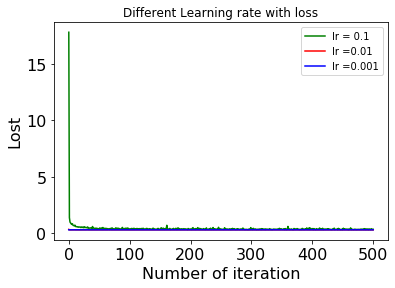

In [359]:

plt.title('Different Learning rate with loss')
plt.plot(loss_hist, color='green', label='lr = 0.1')
plt.plot(loss_hist2, color='red', label='lr =0.01')
plt.plot(loss_hist3, color='blue', label='lr =0.001')
plt.legend()
plt.xlabel('Number of iteration', fontsize = 16)
plt.ylabel('Lost', fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show() 


# plt.plot(x_axix, train_acys, color='green', label='training accuracy')
# plt.plot(sub_axix, test_acys, color='red', label='testing accuracy')
# plt.plot(x_axix, train_pn_dis,  color='skyblue', label='PN distance')
# plt.plot(x_axix, thresholds, color='blue', label='threshold')



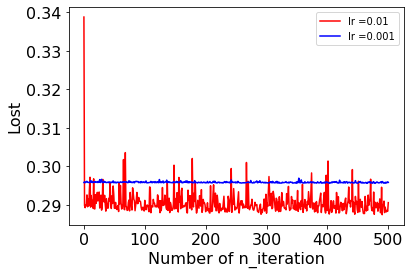

In [357]:
plt.plot(loss_hist2, color='red', label='lr =0.01')
plt.plot(loss_hist3, color='blue', label='lr =0.001')
plt.legend()
plt.xlabel('Number of n_iteration', fontsize = 16)
plt.ylabel('Lost', fontsize = 16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.show() 

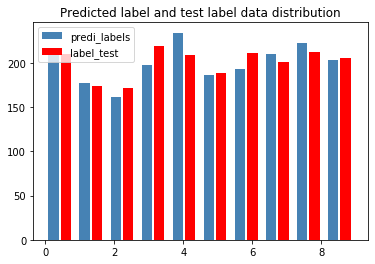

In [361]:
plt.title("Predicted label and test label data distribution")
# plt.hist([label_train,label_test], width=0.8, bins=20, color='steelblue',label='train_label')

plt.hist([predi_labels, label_test],width=0.3, bins=10,color=['steelblue','red'],label=['predi_labels', 'label_test'])

plt.legend()


In [255]:
def plot_classification_report(cr, title='Classification report ', with_avg_total=False, cmap=plt.cm.Blues):

    lines = cr.split('\n')

    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 2)]:
        #print(line)
        t = line.split()
        # print(t)
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        print(v)
        plotMat.append(v)

    if with_avg_total:
        aveTotal = lines[len(lines) - 1].split()
        classes.append('avg/total')
        vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
        plotMat.append(vAveTotal)


    plt.imshow(plotMat, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    x_tick_marks = np.arange(3)
    y_tick_marks = np.arange(len(classes))
    plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
    plt.yticks(y_tick_marks, classes)
    plt.tight_layout()
    plt.ylabel('Classes')
    plt.xlabel('Measures')

In [266]:
from sklearn import metrics
categories = clothClass.values()
print(metrics.classification_report(label_test, predi_labels, target_names=categories))

              precision    recall  f1-score   support

 T-shirt/Top       0.79      0.74      0.76       210
     Trouser       0.95      0.97      0.96       174
    Pullover       0.63      0.77      0.69       171
       Dress       0.81      0.79      0.80       219
        Coat       0.65      0.84      0.73       209
      Sandal       0.91      0.87      0.89       188
       Shirt       0.70      0.37      0.49       211
     Sneaker       0.89      0.92      0.90       201
         Bag       0.89      0.93      0.91       212
  Ankle boot       0.92      0.94      0.93       205

    accuracy                           0.81      2000
   macro avg       0.81      0.81      0.81      2000
weighted avg       0.81      0.81      0.80      2000



[0.84, 0.7, 0.76]
[0.95, 0.98, 0.96]
[0.76, 0.6, 0.67]
[0.75, 0.84, 0.79]
[0.61, 0.89, 0.72]
[0.91, 0.89, 0.9]
[0.62, 0.42, 0.5]
[0.89, 0.9, 0.9]
[0.89, 0.95, 0.92]
[0.93, 0.94, 0.93]


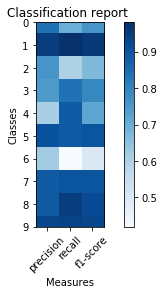

In [267]:
sampleClassificationReport = """              precision    recall  f1-score   support

           0       0.84      0.70      0.76       210
           1       0.95      0.98      0.96       174
           2       0.76      0.60      0.67       171
           3       0.75      0.84      0.79       219
           4       0.61      0.89      0.72       209
           5       0.91      0.89      0.90       188
           6       0.62      0.42      0.50       211
           7       0.89      0.90      0.90       201
           8       0.89      0.95      0.92       212
           9       0.93      0.94      0.93       205

avg / total       0.81      0.81      0.80      2000"""


plot_classification_report(sampleClassificationReport)

## output predicted result 

In [307]:
def predi_output(predi_labels):
	with h5py.File("./output/predicted_labels.h5", "w") as f:
		f.create_dataset('label_predi', data=predi_labels)
		f.close()

In [308]:
predi_output(predi_labels)

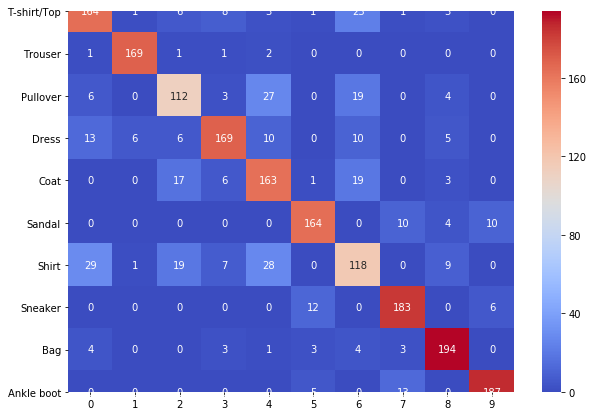

In [398]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conMat = confusion_matrix(label_test,  predi_labels)

df_cm = pd.DataFrame(conMat, index = [clothClass[i] for i in range(10)],columns = [i for i in  range(10)])

plt.figure(figsize = (10,7))
sns.heatmap(df_cm,annot=True, fmt="d",cmap='coolwarm')
plt.show()

In [432]:
from sklearn.neighbors import KNeighborsClassifier


knn = KNeighborsClassifier()

#训练模型
knn.fit(data_train, label_train)

#将准确率打印出
print(knn.score(data_test, label_test))

0.8455


In [438]:
from sklearn import svm
clf = svm.SVC(gamma='scale', decision_function_shape='ovo')
clf.fit(data_train, label_train) 
print(clf.score(data_test, label_test))

KeyboardInterrupt: 

In [ ]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(data_train, label_train) 
print(clf.score(data_test, label_test))


### How to output the prediction
Output a file “predicted_labels.h5” that can be loaded in the same way as above. You may use the following code to generate an output file that meets the requirement:

import numpy as np
# assume output is the predicted labels
# (5000,) with h5py.File('predicted_labels.h5','w') as H:
H.create_dataset('output',data=output)

We will load the output file using the code for loading data above. It is your responsibility to make sure the output file can be correctly loaded using this code.
The performance of your classifier will be evaluated in terms of the top-1 accuracy metric, i.e.<br /><br />
<div style="text-align: center"> $$\text{Accuracy} = \frac{\text{Number of correct classifications}}{\text{Total number of test examples used}} * 100\%$$

## Task description
Each group consists of 3 students. Your task is to determine / build a classifier for the given data set to classify images into categories and write a report. The score allocation is as follows:
    * Classifier (code): max 20 points
    * Report: max 80 points
Please refer to the rubric in Canvas for detailed marking scheme. The report and the code are to be submitted in Canvas by the due date.<br />
This assignment must be submitted in Python3. Although you are allowed to use external libraries for optimisation and linear algebraic calculations, you are NOT allowed to use external libraries for basic pre-processing or classification. For instance, you are allowed to use scipy.optimize for gradient descent or scipy.linalg.svd for matrix decomposition. However, you are NOT allowed to use sklearn.svm for classification (i.e. you have to implement the classifier yourself). If you have any ambiguity whether you can use a particular library or a function, please refer to Canvas -> Modules -> ”Assignment 1 FAQs” for clarification.

## Instructions to hand in the assignment
### Go to Canvas -> Assignments -> "Assignment 1" and submit 2 files only: the report and the code file.
1) Report (a .pdf file): The report should include each member’s details (student IDs and names)<br />
2) Code (a .ipynb file): The code must be able to be run with the following folder structure:
    - Algorithm (the root folder): Your .ipynb file containing Python code will be placed on this folder when we test and run your code. 
    - Input (a sub-folder under Algorithm): We will copy the test dataset into this Input folder when we test and run your code. Please make sure your code is able to read the test dataset from this Input folder.
    - Output (a sub-folder under Algorithm): Your code must be able to generate a prediction file named “predicted_labels.h5” to be saved in this Output folder. The prediction file should contain predicted labels of the test dataset. We will use your prediction output file for grading purpose.

Since this is a group work, only one student from your group needs to submit all the files which must be named with student ID numbers of all your group members separated by underscores e.g. “SID1xxxx_SID2xxxx_SID3xxxx.pdf”,  “SID1xxxx_SID2xxxx_SID3xxxx.ipynb”.

### Your submission should include the report and the code. 
A plagiarism checker will be used. Clearly provide instructions on how to run your code in the Appendix section of your report.

### The report must clearly show :
    1. Details of your classifier 
    2. The predicted results from your classifier on test examples
    3. Run-time
    4. Hardware and software specifications of the computer that you used for performance evaluation

### A template for writing the report 
Note that you have to strictly follow the format of the template. The maximum length of the report is 20 (including references).

### A penalty of MINUS 20 percent (-20%) for each day after the due date. 
The maximum delay for assignment submission is 5 (five) days, after which assignment will not be accepted.

**You should upload your assignment at least half a day or one day prior to the submission deadline to avoid network congestion**.

Canvas may not be able to handle a large number of submission happening at the same time. If you submit your assignment at a time close to the deadline, a submission error may occur causing your submission to be considered late. Penalty will be applied to late submission regardless of issues. 

### All files required for assignment 1 can be downloaded from Canvas -> Assignments -> Assignment 1
